In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import re
import json
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
from Bio.Data import CodonTable
from Bio.Data.CodonTable import NCBICodonTableDNA
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio import Align
from scipy import spatial
import scipy.stats
import tqdm

from pymutspec.annotation import (
    calculate_mutspec, CodonAnnotation, mutations_summary, 
    translator, rev_comp, lbl2lbl_id, lbl_id2lbl
)
from pymutspec.constants import possible_codons, possible_sbs12, possible_sbs192
from pymutspec.io import read_genbank_ref
from pymutspec.draw import plot_mutspec12, plot_mutspec192, plot_mutspec192kk
from pymutspec.draw.sbs_orders import ordered_sbs192_kp as ordered_sbs192

sns.set_style("whitegrid")
coda = CodonAnnotation(2)

In [2]:
transitions = ["A>G","G>A","T>C","C>T"]
transversions = [x for x in possible_sbs12 if x not in transitions]

In [3]:
def nuc_freqs2sbsfreqs(nuc_freqs: dict) -> dict:
    nucs = "ACGT"
    for nuc in nucs:
        assert nuc in nuc_freqs

    sbs_freqs = dict()
    for nuc1 in nucs:
        for nuc2 in nucs:
            if nuc1 != nuc2:
                sbs_freqs[f"{nuc1}>{nuc2}"] = nuc_freqs[nuc1]
    return sbs_freqs

## GTEx (mtRNA)

In [4]:
gtex = pd.read_csv("../data/external/GTExRef.txt", )
gb_refseq_gtex = next(SeqIO.parse("../data/external/gtex_refseq.gb", "gb"))

assert (gtex.AncestralAllele == gtex.Position.map({i:x for i, x in enumerate(gb_refseq_gtex.seq, 1)})).all()

refseq_gtex = read_genbank_ref(gb_refseq_gtex)
refseq_gtex.loc[refseq_gtex["Codon"] == "TA", "Codon"] = "TAA"

gtex["Substitution"] = gtex.Substitution.str.replace("_", ">")
print(gtex.shape)
gtex.head()

(2565, 14)


,Position,Mutation,SRR,AF,tissue,subject,nDonorTissue,BQ,COV,OTHERS_DONOR_AF,OTHERS_DONOR_COV,DerivedAllele,AncestralAllele,Substitution
0,1554,1554_A,SRR1500555,0.1021,Artery - Tibial,GTEX-1117F,13,35.7,186,0.0012,1241.3,A,G,G>A
1,16215,16215_A,SRR1413373,0.0525,Ovary,GTEX-1117F,13,37.9,362,0.0000,1421.8,A,G,G>A
2,4006,4006_G,SRR1413373,0.0930,Ovary,GTEX-1117F,13,37.5,3418,0.0001,31757.6,G,A,A>G
3,458,458_T,SRR1413373,0.0340,Ovary,GTEX-1117F,13,35.1,206,0.0000,614.0,T,C,C>T
4,67,67_A,SRR1309070,0.0604,Muscle - Skeletal,GTEX-1117F,13,35.5,745,0.0003,590.0,A,G,G>A


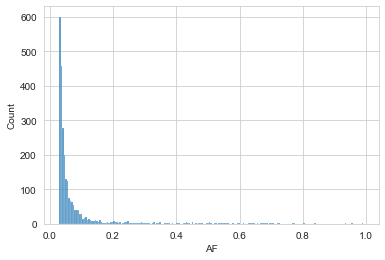

In [5]:
sns.histplot(gtex.AF);

In [9]:
gtex_annotated = gtex.merge(refseq_gtex, left_on="Position", right_on="Pos")

assert (gtex_annotated.Nuc == gtex_annotated.AncestralAllele).all()
assert gtex_annotated.shape[0] == gtex.shape[0]

gtex_annotated["Mut"] = gtex_annotated.Context.str.get(0) + "[" + gtex_annotated.Substitution + "]" + gtex_annotated.Context.str.get(-1)
gtex_annotated.to_csv("../data/stem_and_workers/gtex_annotated.csv", index=False)

gtex_filtered = gtex_annotated[(gtex_annotated.Type == "CDS") & (gtex_annotated.Strand == 1)]
gtex_filtered["AltCodon"] = gtex_filtered.apply(lambda x: "".join([x.Codon[i] if i != x.PosInCodon-1 else x.DerivedAllele for i in range(3)]), axis=1)
gtex_filtered["Label"] = gtex_filtered.apply(lambda x: coda.get_mut_type(x.Codon, x.AltCodon, x.PosInCodon-1)[0], axis=1)
print(gtex_filtered.shape)
gtex_filtered.head()

(1252, 26)


,Position,Mutation,SRR,AF,tissue,subject,nDonorTissue,BQ,COV,OTHERS_DONOR_AF,...,Context,Strand,Type,product,PosInGene,PosInCodon,Codon,Mut,AltCodon,Label
5,4006,4006_G,SRR1413373,0.0930,Ovary,GTEX-1117F,13,37.5,3418,0.0001,...,TAA,1,CDS,NADH dehydrogenase subunit 1,699,3,ATA,T[A>G]A,ATG,1
6,4006,4006_G,SRR659169,0.0366,Whole Blood,GTEX-QDT8,29,29.5,1529,0.0005,...,TAA,1,CDS,NADH dehydrogenase subunit 1,699,3,ATA,T[A>G]A,ATG,1
7,4006,4006_G,SRR660042,0.0306,Whole Blood,GTEX-SNMC,15,33.6,1959,0.0004,...,TAA,1,CDS,NADH dehydrogenase subunit 1,699,3,ATA,T[A>G]A,ATG,1
21,7029,7029_C,SRR1413373,0.0364,Ovary,GTEX-1117F,13,37.4,4233,0.0014,...,CTC,1,CDS,cytochrome c oxidase subunit I,1125,3,GCT,C[T>C]C,GCC,2
22,7029,7029_C,SRR1456591,0.0457,Thyroid,GTEX-11P82,21,37.3,157843,0.0008,...,CTC,1,CDS,cytochrome c oxidase subunit I,1125,3,GCT,C[T>C]C,GCC,2


In [7]:
refseq_gtex["SynCodons"] = refseq_gtex.apply(lambda x: coda.get_syn_codons(x.Codon, x.PosInCodon-1) if x.PosInCodon >= 0 else {}, axis=1)
refseq_gtex["Is4Fold"] = refseq_gtex["SynCodons"].apply(len) == 3

# ONLY CDS
refseq_gtex_cds = refseq_gtex[(refseq_gtex.Type == "CDS") & (refseq_gtex.Strand == 1)]

exp12all_gtex = nuc_freqs2sbsfreqs(refseq_gtex_cds.Nuc.value_counts().to_dict())


possible_syn_sbs_gtex = refseq_gtex_cds.explode("SynCodons", ignore_index=True).dropna(subset="SynCodons")
possible_syn_sbs_gtex["Nuc2"] = possible_syn_sbs_gtex.apply(lambda x: x.SynCodons[x.PosInCodon-1], axis=1)
possible_syn_sbs_gtex["Sbs"] = possible_syn_sbs_gtex["Nuc"] + ">" + possible_syn_sbs_gtex["Nuc2"]

exp12syn_gtex = possible_syn_sbs_gtex["Sbs"].value_counts().to_dict()
possible_syn_sbs_gtex.head()

,Pos,Nuc,Context,Strand,Type,product,PosInGene,PosInCodon,Codon,SynCodons,Is4Fold,Nuc2,Sbs
2,3310,A,TAC,1,CDS,NADH dehydrogenase subunit 1,3,3,ATA,ATG,False,G,A>G
5,3313,C,CCA,1,CDS,NADH dehydrogenase subunit 1,6,3,CCC,CCT,True,T,C>T
6,3313,C,CCA,1,CDS,NADH dehydrogenase subunit 1,6,3,CCC,CCG,True,G,C>G
7,3313,C,CCA,1,CDS,NADH dehydrogenase subunit 1,6,3,CCC,CCA,True,A,C>A
10,3316,G,TGG,1,CDS,NADH dehydrogenase subunit 1,9,3,ATG,ATA,False,A,G>A


## Cancer TCGA (mtDNA)

In [8]:
tcga = pd.read_csv("../data/processed/mutations.csv")
tcga_filtered = tcga[(tcga.Type == "CDS") & (tcga.Strand == 1)]
tcga_filtered["Sbs12"] = tcga_filtered.Mut.str.slice(2,5)

print(tcga_filtered.shape[0])
tcga_filtered.head()

4505


,tissue,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,AltCodon,Label,Mut,Sbs12
2,Bladder,200.0,10.1400,6011,T,TTA,1,CDS,COX1,108,3,CTT,426.0,CTC,2,T[T>C]A,T>C
3,Bladder,200.0,37.3900,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C,G>A
4,Esophagus,11.0,0.7013,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C,G>A
5,Liver,400.0,4.8500,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C,G>A
6,Pancreas,360.0,5.7100,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C,G>A


In [9]:
refseq_rCRS = pd.read_csv("../data/processed/ref_annot.csv")
refseq_rCRS = refseq_rCRS[refseq_rCRS.Strand == 1]
refseq_rCRS["SynCodons"] = refseq_rCRS.apply(lambda x: coda.get_syn_codons(x.Codon, x.PosInCodon-1) if x.PosInCodon >= 0 else {}, axis=1)
refseq_rCRS["Is4Fold"] = refseq_rCRS["SynCodons"].apply(len) == 3

# ONLY CDS
refseq_rCRS_cds = refseq_rCRS[(refseq_rCRS.Type == "CDS")]

exp12all_tcga = nuc_freqs2sbsfreqs(refseq_rCRS_cds.Nuc.value_counts().to_dict())


possible_syn_sbs_rCRS = refseq_rCRS_cds.explode("SynCodons", ignore_index=True).dropna(subset="SynCodons")
possible_syn_sbs_rCRS["Nuc2"] = possible_syn_sbs_rCRS.apply(lambda x: x.SynCodons[x.PosInCodon-1], axis=1)
possible_syn_sbs_rCRS["Sbs"] = possible_syn_sbs_rCRS["Nuc"] + ">" + possible_syn_sbs_rCRS["Nuc2"]

exp12syn_tcga = possible_syn_sbs_rCRS["Sbs"].value_counts().to_dict()
possible_syn_sbs_rCRS.head()

,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,SynCodons,Is4Fold,Nuc2,Sbs
2,3309,A,TAC,1,CDS,ND1,3,3,ATA,11745.0,ATG,False,G,A>G
5,3312,C,CCA,1,CDS,ND1,6,3,CCC,11751.0,CCT,True,T,C>T
6,3312,C,CCA,1,CDS,ND1,6,3,CCC,11751.0,CCG,True,G,C>G
7,3312,C,CCA,1,CDS,ND1,6,3,CCC,11751.0,CCA,True,A,C>A
10,3315,G,TGG,1,CDS,ND1,9,3,ATG,11757.0,ATA,False,A,G>A


## Compare spectra

In [11]:
ms_gtex_all = calculate_mutspec(gtex_filtered[gtex_filtered.Label >= 0], exp12all_gtex)
ms_gtex_syn = calculate_mutspec(gtex_filtered[gtex_filtered.Label >= 1], exp12syn_gtex)

ms_tcga_all = calculate_mutspec(tcga_filtered[tcga_filtered.Label >= 0], exp12all_tcga)
ms_tcga_syn = calculate_mutspec(tcga_filtered[tcga_filtered.Label >= 1], exp12syn_tcga)

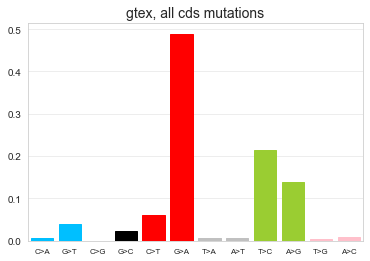

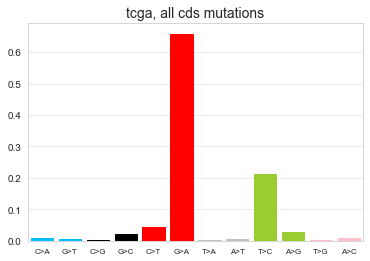

In [14]:
plot_mutspec12(ms_gtex_all, title="gtex, all cds mutations", fontname="Arial")
plot_mutspec12(ms_tcga_all, title="tcga, all cds mutations", fontname="Arial");

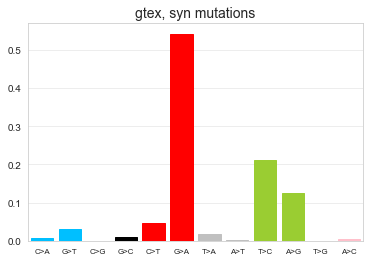

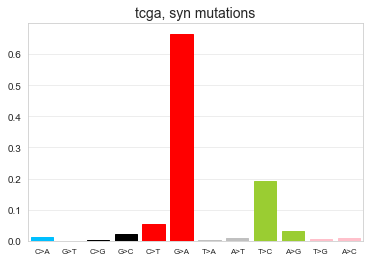

In [15]:
plot_mutspec12(ms_gtex_syn, title="gtex, syn mutations", fontname="Arial")
plot_mutspec12(ms_tcga_syn, title="tcga, syn mutations", fontname="Arial");

### tcga VS gtex - all cds mutations

In [18]:
compare_all = ms_gtex_all.merge(ms_tcga_all, on="Mut", suffixes=["_gtex", "_tcga"]).drop(["RawMutSpec_gtex", "RawMutSpec_tcga"], axis=1)#.sum(axis=0)
compare_all["ObsNum_gtex_percent"] = compare_all["ObsNum_gtex"] / compare_all["ObsNum_gtex"].sum() * 100
compare_all["ObsNum_tcga_percent"] = compare_all["ObsNum_tcga"] / compare_all["ObsNum_tcga"].sum() * 100
compare_all["ObsNum_percent_diff"] = (compare_all["ObsNum_gtex_percent"] - compare_all["ObsNum_tcga_percent"]).abs()
compare_all["ObsNum_percent_quotient"] = (compare_all["ObsNum_gtex_percent"] / compare_all["ObsNum_tcga_percent"]).abs()
_summa = compare_all.sum(axis=0).head(9)
_summa["Mut"] = "ALL"
x = compare_all.append(_summa, ignore_index=True).round(2).sort_values("ObsNum_percent_quotient").reset_index(drop=True)
x.to_csv("../data/stem_and_workers/tcga_versus_gtex_all_mutations.csv", index=False)
x

,Mut,ObsNum_gtex,ExpNum_gtex,MutSpec_gtex,ObsNum_tcga,ExpNum_tcga,MutSpec_tcga,ObsNum_gtex_percent,ObsNum_tcga_percent,ObsNum_percent_diff,ObsNum_percent_quotient
0,C>G,0,3581,0.00,8,3583,0.00,0.00,0.19,0.19,0.00
1,G>A,371,1297,0.49,1979,1295,0.66,30.64,46.93,16.29,0.65
2,C>A,16,3581,0.01,83,3583,0.01,1.32,1.97,0.65,0.67
3,T>C,347,2763,0.21,1371,2767,0.21,28.65,32.51,3.86,0.88
4,G>C,18,1297,0.02,68,1295,0.02,1.49,1.61,0.13,0.92
5,A>C,17,3165,0.01,58,3171,0.01,1.40,1.38,0.03,1.02
6,A>T,13,3165,0.01,41,3171,0.01,1.07,0.97,0.10,1.10
7,C>T,128,3581,0.06,361,3583,0.04,10.57,8.56,2.01,1.23
8,T>G,6,2763,0.00,11,2767,0.00,0.50,0.26,0.23,1.90
9,T>A,9,2763,0.01,10,2767,0.00,0.74,0.24,0.51,3.13


### tcga VS gtex - syn mutations

In [17]:
compare_syn = ms_gtex_syn.merge(ms_tcga_syn, on="Mut", suffixes=["_gtex", "_tcga"]).drop(["RawMutSpec_gtex", "RawMutSpec_tcga"], axis=1)#.sum(axis=0)
compare_syn["ObsNum_gtex_percent"] = compare_syn["ObsNum_gtex"] / compare_syn["ObsNum_gtex"].sum() * 100
compare_syn["ObsNum_tcga_percent"] = compare_syn["ObsNum_tcga"] / compare_syn["ObsNum_tcga"].sum() * 100
compare_syn["ObsNum_percent_diff"] = (compare_syn["ObsNum_gtex_percent"] - compare_syn["ObsNum_tcga_percent"]).abs()
compare_syn["ObsNum_percent_quotient"] = (compare_syn["ObsNum_gtex_percent"] / compare_syn["ObsNum_tcga_percent"]).abs()
_summa = compare_syn.sum(axis=0).head(9)
_summa["Mut"] = "ALL"
compare_syn.append(_summa, ignore_index=True).round(2).sort_values("ObsNum_percent_quotient").reset_index(drop=True)
x = compare_syn.append(_summa, ignore_index=True).round(2).sort_values("ObsNum_percent_quotient").reset_index(drop=True)
x.to_csv("../data/stem_and_workers/tcga_versus_gtex_syn_mutations.csv", index=False)
x

,Mut,ObsNum_gtex,ExpNum_gtex,MutSpec_gtex,ObsNum_tcga,ExpNum_tcga,MutSpec_tcga,ObsNum_gtex_percent,ObsNum_tcga_percent,ObsNum_percent_diff,ObsNum_percent_quotient
0,T>G,0,260,0.00,3,263,0.01,0.00,0.36,0.36,0.00
1,C>G,0,821,0.00,4,820,0.00,0.00,0.48,0.48,0.00
2,A>T,2,770,0.00,12,768,0.01,0.38,1.44,1.06,0.26
3,G>C,1,95,0.01,4,96,0.02,0.19,0.48,0.29,0.40
4,A>C,4,770,0.00,12,768,0.01,0.76,1.44,0.68,0.53
5,C>A,7,821,0.01,20,820,0.01,1.33,2.40,1.07,0.55
6,G>A,101,177,0.54,242,178,0.67,19.13,28.98,9.85,0.66
7,C>T,94,1876,0.05,209,1875,0.05,17.80,25.03,7.23,0.71
8,T>C,139,622,0.21,244,625,0.19,26.33,29.22,2.90,0.90
9,A>G,172,1312,0.12,84,1312,0.03,32.58,10.06,22.52,3.24


### TsTv tissie-specific

In [22]:
gtex_tissue2sbs = gtex_filtered[gtex_filtered.Label >= 0].groupby(["tissue",]).Substitution.value_counts().unstack().fillna(0)
for sbs12 in set(possible_sbs12).difference(gtex_tissue2sbs.columns):
    gtex_tissue2sbs[sbs12] = 0
gtex_tissue2sbs = gtex_tissue2sbs[possible_sbs12].astype(int)
gtex_tissue2sbs["Ts"] = gtex_tissue2sbs[transitions].sum(axis=1)
gtex_tissue2sbs["Tv"] = gtex_tissue2sbs[[x for x in gtex_tissue2sbs.columns if x in transversions]].sum(axis=1)
gtex_tissue2sbs["TsTv"] = gtex_tissue2sbs.Ts / gtex_tissue2sbs.Tv
gtex_tissue2sbs.round(2).replace(np.inf, np.nan).to_csv("../data/stem_and_workers/gtex_tissue2obs.csv")

tissue_mapper = {
    "Skin - Not Sun Exposed (Suprapubic)": "Skin",
    "Skin - Sun Exposed (Lower leg)": "Skin",
    "Colon - Sigmoid": "Colon",
    "Colon - Transverse": "Colon",
    "Breast - Mammary Tissue": "Breast",
    "Kidney - Cortex": "Kidney",
    "Brain - Hippocampus": "CNS",
    "Brain - Nucleus accumbens (basal ganglia)": "CNS",
    "Brain - Spinal cord (cervical c-1)": "CNS",
    "": "",
    "": "",
}
gtex_tissue2sbs.index = gtex_tissue2sbs.index.to_series().replace(tissue_mapper)
gtex_tissue2sbs.round(2)

Substitution,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,Ts,Tv,TsTv
tissue,,,,,,,,,,,,,,,
Adipose - Subcutaneous,1,2,2,0,0,3,4,0,6,0,6,0,15,9,1.67
Adipose - Visceral (Omentum),0,3,2,0,0,0,5,0,1,0,3,0,11,3,3.67
Adrenal Gland,1,3,0,0,0,0,4,0,0,0,6,0,13,1,13.00
Artery - Aorta,0,14,0,3,0,8,12,1,0,1,10,0,44,5,8.80
Artery - Coronary,0,0,0,0,0,0,0,0,0,0,1,0,1,0,inf
Artery - Tibial,0,4,1,1,0,6,9,0,0,0,5,0,24,2,12.00
CNS,0,1,0,0,0,0,0,0,0,0,2,0,3,0,inf
CNS,0,0,0,0,0,1,0,0,0,0,0,0,1,0,inf
CNS,0,0,0,0,0,0,2,0,0,0,0,0,2,0,inf


In [23]:
tcga_tissue2sbs = tcga_filtered[tcga_filtered.Label >= 0].groupby(["tissue",]).Sbs12.value_counts().unstack().fillna(0)
for sbs12 in set(possible_sbs12).difference(tcga_tissue2sbs.columns):
    tcga_tissue2sbs[sbs12] = 0
tcga_tissue2sbs = tcga_tissue2sbs[possible_sbs12].astype(int)
tcga_tissue2sbs["Ts"] = tcga_tissue2sbs[transitions].sum(axis=1)
tcga_tissue2sbs["Tv"] = tcga_tissue2sbs[transversions].sum(axis=1)
tcga_tissue2sbs["TsTv"] = tcga_tissue2sbs.Ts / tcga_tissue2sbs.Tv
tcga_tissue2sbs.round(2).replace(np.inf, np.nan).to_csv("../data/stem_and_workers/tcga_tissue2obs.csv")

tissue_mapper2 = {
    "Colon/Rectum": "Colon",
    "": "",
    "": "",
    "": "",
}
tcga_tissue2sbs.index = tcga_tissue2sbs.index.to_series().replace(tissue_mapper2)
tcga_tissue2sbs.round(2)

Sbs12,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,Ts,Tv,TsTv
tissue,,,,,,,,,,,,,,,
Biliary,0,2,1,1,0,7,30,1,0,0,17,0,56,3,18.67
Bladder,1,1,0,1,0,4,25,2,1,0,20,1,50,6,8.33
Bone/SoftTissue,0,5,0,0,0,9,40,1,1,0,27,2,81,4,20.25
Breast,3,19,3,7,1,27,130,7,1,2,158,2,334,26,12.85
CNS,10,8,0,3,0,10,56,1,1,1,62,1,136,17,8.00
Cervix,0,2,0,0,1,5,12,0,0,0,5,0,24,1,24.00
Colon,3,5,3,0,0,19,53,2,0,1,20,0,97,9,10.78
Esophagus,6,12,7,6,0,21,97,4,0,1,70,0,200,24,8.33
Head/Neck,1,2,1,1,0,15,26,4,0,0,15,0,58,7,8.29


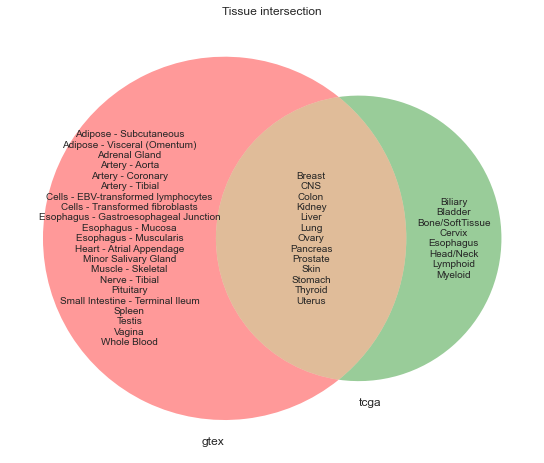

In [89]:
A = set(gtex_tissue2sbs.index)
B = set(tcga_tissue2sbs.index)


plt.figure(figsize=(12, 8))
plt.title("Tissue intersection")
v = venn2([A,B], ('gtex', 'tcga'))

v.get_label_by_id('10').set_text('\n'.join(sorted(A-B)))
v.get_label_by_id('11').set_text('\n'.join(sorted(A&B)))
v.get_label_by_id('01').set_text('\n'.join(sorted(B-A)))
plt.show()

In [96]:
compare_tstv = gtex_tissue2sbs.loc[A&B, ["Ts", "Tv", "TsTv"]].merge(
    tcga_tissue2sbs.loc[A&B, ["Ts", "Tv", "TsTv"]], 
    right_index=True, left_index=True, suffixes=["_gtex", "_tcga"]).reset_index()#.drop_duplicates("tissue")
compare_tstv

,tissue,Ts_gtex,Tv_gtex,TsTv_gtex,Ts_tcga,Tv_tcga,TsTv_tcga
0,Breast,10,6,1.666667,334,26,12.846154
1,CNS,3,0,inf,136,17,8.000000
2,CNS,1,0,inf,136,17,8.000000
3,CNS,2,0,inf,136,17,8.000000
4,Colon,9,0,inf,97,9,10.777778
5,Colon,3,0,inf,97,9,10.777778
6,Kidney,9,0,inf,394,49,8.040816
7,Liver,38,3,12.666667,665,39,17.051282
8,Lung,19,2,9.500000,154,6,25.666667
9,Ovary,28,0,inf,220,13,16.923077


In [97]:
_cur_gtex = gtex_tissue2sbs.loc[A&B, possible_sbs12].groupby("tissue").sum()
_cut_tcga = tcga_tissue2sbs.loc[A&B, possible_sbs12]

compare_obs = _cur_gtex.merge(
    _cut_tcga, right_index=True, left_index=True, suffixes=["_gtex", "_tcga"])\

compare_obs = compare_obs[compare_obs.columns.sort_values()]
compare_obs.to_csv("../data/stem_and_workers/tissue_specific_compare_obs.csv")
compare_obs

,A>C_gtex,A>C_tcga,A>G_gtex,A>G_tcga,A>T_gtex,A>T_tcga,C>A_gtex,C>A_tcga,C>G_gtex,C>G_tcga,...,G>C_gtex,G>C_tcga,G>T_gtex,G>T_tcga,T>A_gtex,T>A_tcga,T>C_gtex,T>C_tcga,T>G_gtex,T>G_tcga
tissue,,,,,,,,,,,,,,,,,,,,,
Breast,1,3,1,19,1,3,0,7,0,1,...,0,7,4,1,0,2,4,158,0,2
CNS,0,10,1,8,0,0,0,3,0,0,...,0,1,0,1,0,1,2,62,0,1
Colon,0,3,3,5,0,3,0,0,0,0,...,0,2,0,0,0,1,4,20,0,0
Kidney,0,10,3,29,0,7,0,16,0,0,...,0,10,0,2,0,2,3,112,0,2
Liver,2,6,2,33,0,7,0,12,0,0,...,1,10,0,3,0,1,12,225,0,0
Lung,1,2,6,4,0,0,0,1,0,1,...,0,2,0,0,0,0,5,39,1,0
Ovary,0,2,9,13,0,2,0,2,0,0,...,0,5,0,2,0,0,9,92,0,0
Pancreas,0,1,2,26,1,3,1,12,0,1,...,0,10,0,3,0,0,2,143,0,1
Prostate,0,1,1,10,0,2,0,6,0,1,...,0,3,0,0,0,2,13,138,0,2


In [98]:
_xxx = gtex_tissue2sbs[possible_sbs12].groupby("tissue").sum()
_yyy = tcga_tissue2sbs[possible_sbs12]
_cur_gtex = ((_xxx.T / _xxx.sum(axis=1)).T * 100)
_cut_tcga = ((_yyy.T / _yyy.sum(axis=1)).T * 100)

compare_obs_percents = _cur_gtex.merge(
    _cut_tcga, right_index=True, left_index=True, suffixes=["_gtex", "_tcga"])\

compare_obs_percents = compare_obs_percents[compare_obs_percents.columns.sort_values()]
compare_obs_percents.to_csv("../data/stem_and_workers/tissue_specific_compare_obs_percents.csv", float_format="%.2f")
compare_obs_percents

,A>C_gtex,A>C_tcga,A>G_gtex,A>G_tcga,A>T_gtex,A>T_tcga,C>A_gtex,C>A_tcga,C>G_gtex,C>G_tcga,...,G>C_gtex,G>C_tcga,G>T_gtex,G>T_tcga,T>A_gtex,T>A_tcga,T>C_gtex,T>C_tcga,T>G_gtex,T>G_tcga
tissue,,,,,,,,,,,,,,,,,,,,,
Breast,6.250000,0.833333,6.250000,5.277778,6.250000,0.833333,0.000000,1.944444,0.0,0.277778,...,0.000000,1.944444,25.000000,0.277778,0.000000,0.555556,25.000000,43.888889,0.000000,0.555556
CNS,0.000000,6.535948,16.666667,5.228758,0.000000,0.000000,0.000000,1.960784,0.0,0.000000,...,0.000000,0.653595,0.000000,0.653595,0.000000,0.653595,33.333333,40.522876,0.000000,0.653595
Colon,0.000000,2.830189,25.000000,4.716981,0.000000,2.830189,0.000000,0.000000,0.0,0.000000,...,0.000000,1.886792,0.000000,0.000000,0.000000,0.943396,33.333333,18.867925,0.000000,0.000000
Kidney,0.000000,2.257336,33.333333,6.546275,0.000000,1.580135,0.000000,3.611738,0.0,0.000000,...,0.000000,2.257336,0.000000,0.451467,0.000000,0.451467,33.333333,25.282167,0.000000,0.451467
Liver,4.878049,0.852273,4.878049,4.687500,0.000000,0.994318,0.000000,1.704545,0.0,0.000000,...,2.439024,1.420455,0.000000,0.426136,0.000000,0.142045,29.268293,31.960227,0.000000,0.000000
Lung,4.761905,1.250000,28.571429,2.500000,0.000000,0.000000,0.000000,0.625000,0.0,0.625000,...,0.000000,1.250000,0.000000,0.000000,0.000000,0.000000,23.809524,24.375000,4.761905,0.000000
Ovary,0.000000,0.858369,32.142857,5.579399,0.000000,0.858369,0.000000,0.858369,0.0,0.000000,...,0.000000,2.145923,0.000000,0.858369,0.000000,0.000000,32.142857,39.484979,0.000000,0.000000
Pancreas,0.000000,0.202429,20.000000,5.263158,10.000000,0.607287,10.000000,2.429150,0.0,0.202429,...,0.000000,2.024291,0.000000,0.607287,0.000000,0.000000,20.000000,28.947368,0.000000,0.202429
Prostate,0.000000,0.248139,5.000000,2.481390,0.000000,0.496278,0.000000,1.488834,0.0,0.248139,...,0.000000,0.744417,0.000000,0.000000,0.000000,0.496278,65.000000,34.243176,0.000000,0.496278


In [99]:
compare_obs_percents.sum(axis=1)

tissue
Breast      200.0
CNS         200.0
Colon       200.0
Kidney      200.0
Liver       200.0
Lung        200.0
Ovary       200.0
Pancreas    200.0
Prostate    200.0
Skin        200.0
Stomach     200.0
Thyroid     200.0
Uterus      200.0
dtype: float64

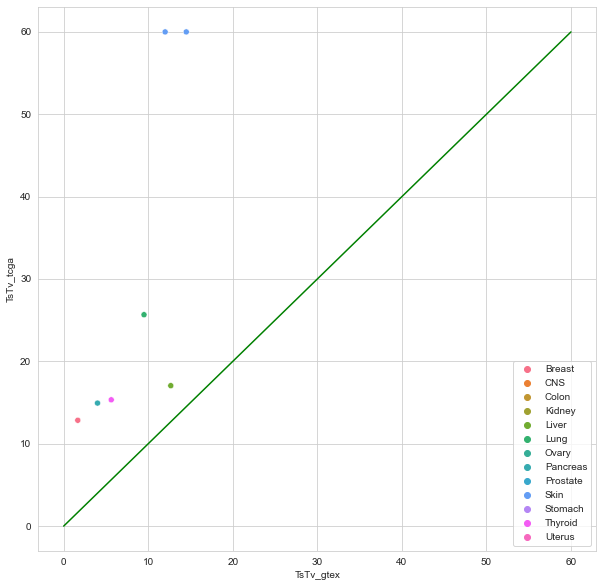

In [101]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=compare_tstv, x="TsTv_gtex", y = "TsTv_tcga", hue="tissue")
sns.lineplot(x=[0, 60], y=[0, 60], color="green")
# plt.xlim((0.6, 1.01))
# plt.ylim((0.6, 1.01))
plt.legend(loc="lower right")
plt.show()

## GTEx Transversions list

In [78]:
cols = ['Position','PosInGene', 'PosInCodon', 'tissue', 'product', 
        'Substitution', 'Mut','AF','nDonorTissue', 'BQ', 'COV',
        'OTHERS_DONOR_AF', 'OTHERS_DONOR_COV', 'Strand', 'Context', 'Codon', 'Type', 'IsSyn', 'Is4Fold',]

gtex_filtered_tv = gtex_filtered.loc[gtex_filtered.Substitution.isin(transversions)].sort_values(["tissue", "product", "Position"])
gtex_filtered_tv["IsSyn"] = gtex_filtered_tv.Label >= 1
gtex_filtered_tv = gtex_filtered_tv.loc[:, cols]
gtex_filtered_tv.to_csv("../data/stem_and_workers/gtex_filtered_tv.csv", index=False)
gtex_filtered_tv

,Position,PosInGene,PosInCodon,tissue,product,Substitution,Mut,AF,nDonorTissue,BQ,COV,OTHERS_DONOR_AF,OTHERS_DONOR_COV,Strand,Context,Codon,Type,IsSyn,Is4Fold
121,11915,1155,3,Adipose - Subcutaneous,NADH dehydrogenase subunit 4,G>T,C[G>T]T,0.1097,22,36.8,78306,0.0004,158096.0,1,CGT,ACG,CDS,True,True
2150,10755,285,3,Adipose - Subcutaneous,NADH dehydrogenase subunit 4L,A>C,T[A>C]C,0.0409,14,36.6,38727,0.0003,58324.2,1,TAC,CTA,CDS,True,True
1959,12348,11,2,Adipose - Subcutaneous,NADH dehydrogenase subunit 5,A>T,C[A>T]C,0.0430,16,38.9,256,0.0002,188.3,1,CAC,CAC,CDS,False,False
974,13346,1009,1,Adipose - Subcutaneous,NADH dehydrogenase subunit 5,G>T,A[G>T]C,0.0740,22,35.9,6351,0.0002,18477.7,1,AGC,GCC,CDS,False,False
978,5984,80,2,Adipose - Subcutaneous,cytochrome c oxidase subunit I,G>T,G[G>T]A,0.0335,22,34.5,18372,0.0007,66240.0,1,GGA,GGA,CDS,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,15453,706,1,Whole Blood,cytochrome b,C>A,C[C>A]T,0.1699,17,31.0,3943,0.0010,32690.6,1,CCT,CTT,CDS,False,False
2048,15488,741,3,Whole Blood,cytochrome b,A>T,C[A>T]G,0.0423,19,34.5,6473,0.0001,58483.6,1,CAG,CCA,CDS,True,True
1787,7197,1293,3,Whole Blood,cytochrome c oxidase subunit I,C>A,T[C>A]G,0.0478,19,34.5,14973,0.0003,52921.5,1,TCG,CTC,CDS,True,True
1405,7596,10,1,Whole Blood,cytochrome c oxidase subunit II,G>T,T[G>T]C,0.0435,19,39.0,115,0.0000,1239.9,1,TGC,GCA,CDS,False,False


In [84]:
gtex_annotated[(gtex_annotated.Substitution.isin(transversions))].Type.value_counts()

tRNA      142
CDS       112
D-loop     44
rRNA       34
Name: Type, dtype: int64

## Tissue-specific precise compare

In [217]:
_cur_gtex = gtex_tissue2sbs.loc[A&B, possible_sbs12].groupby("tissue").sum()
_cur_tcga = tcga_tissue2sbs.loc[A&B, possible_sbs12]

_cur_gtex = _cur_gtex.append(gtex_tissue2sbs[possible_sbs12].sum(axis=0).rename("_TOTAL"))
_cur_tcga = _cur_tcga.append(tcga_tissue2sbs[possible_sbs12].sum(axis=0).rename("_TOTAL"))

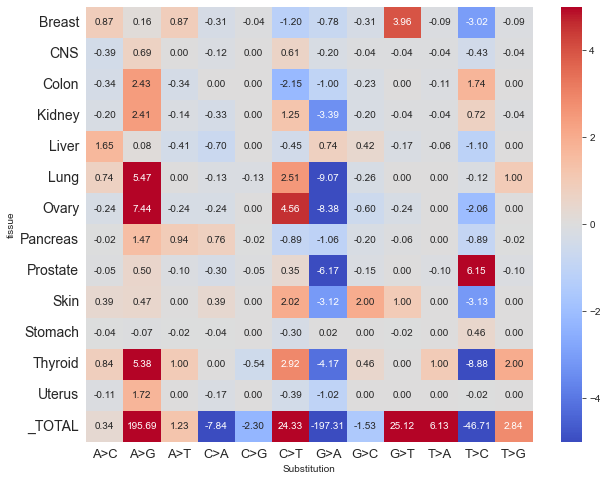

In [218]:
obs = _cur_gtex
exp = (_cur_tcga.T / _cur_tcga.sum(axis=1) * _cur_gtex.sum(axis=1)).T
d = obs - exp

plt.figure(figsize=(10, 8))
sns.heatmap(d, annot=True, fmt=".2f", cmap="coolwarm", vmin=-5, vmax=5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=14)
plt.show()

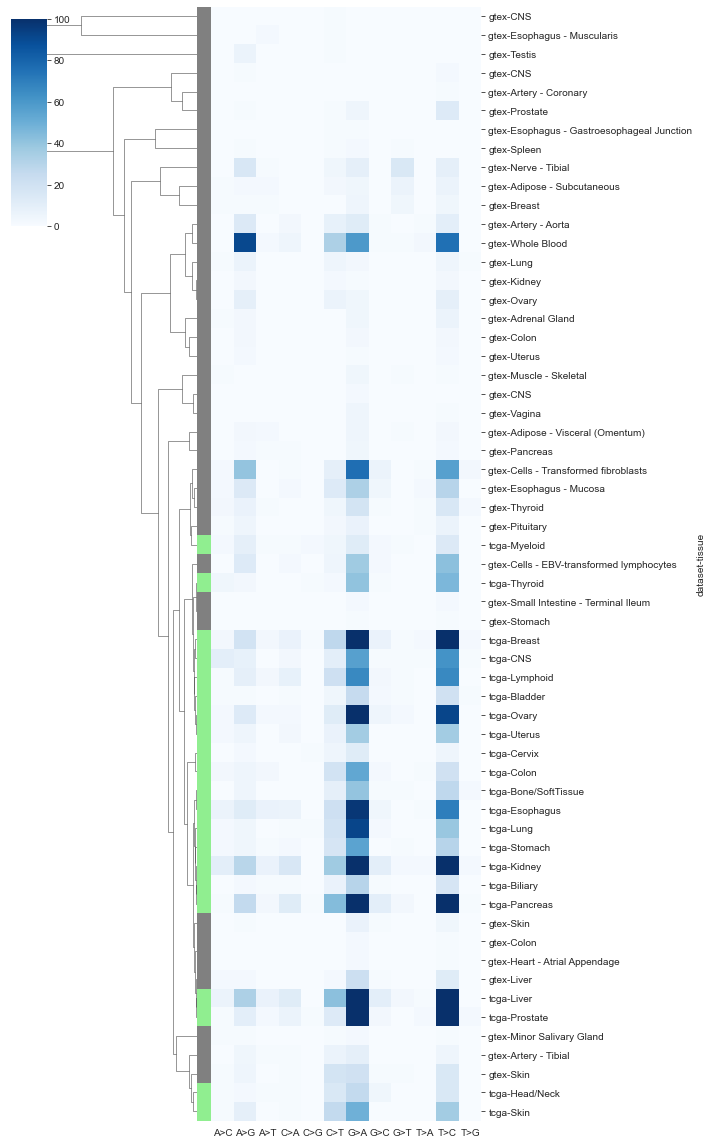

In [171]:
d = pd.concat([
        gtex_tissue2sbs[possible_sbs12].reset_index().assign(dataset="gtex"), 
        tcga_tissue2sbs[possible_sbs12].reset_index().assign(dataset="tcga")],
    ).set_index(["dataset", "tissue"])

lut = dict(zip(d.index.get_level_values(0).unique(), ["gray", "lightgreen"]))
row_colors = d.index.get_level_values(0).map(lut)

sns.clustermap(d, metric="cosine", cmap="Blues", col_cluster=False, vmax=100, figsize=(10,16), dendrogram_ratio=(0.4, 0.), row_colors=row_colors)